In [1]:
from torchinfo import summary
import torch
import mlflow
import mlflow.pytorch
import os
# connect the experiment to the tracking server
mlflow.set_tracking_uri("http://127.0.0.1:5000")

# set the experiment name
mlflow.set_experiment("SPAD-multi-scale-DNN-model")

# enable autologging
mlflow.pytorch.autolog()


In [2]:
# Set up logging to a file
import logging

# Get current working directory
log_file_path = os.path.join(os.getcwd(), 'training.log')

# Set up the logger manually
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# Remove all previous handlers (important in Jupyter)
logger.handlers.clear()

# Create and add FileHandler
file_handler = logging.FileHandler(log_file_path, mode='w')
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

# Optional: also log to console
console_handler = logging.StreamHandler()
console_handler.setFormatter(formatter)
logger.addHandler(console_handler)

In [3]:
import random
import numpy as np
import torch

def set_seed(seed=42):
    """
    Set the seed for reproducibility in PyTorch, NumPy, and Python's random module.
    Ensures deterministic behavior on CPU, CUDA, and MPS.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)  # Works for CPU & MPS

    if torch.backends.mps.is_available():
        logging.info("MPS backend is available. It uses the global PyTorch seed.")

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # Multi-GPU
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    torch.use_deterministic_algorithms(True, warn_only=True)
    logging.info("Deterministic algorithms set to True.")
    logging.info("Random seed set to: %d", seed)

# Example usage
global_seed = 42
set_seed(global_seed)

2025-04-11 00:33:38,581 - INFO - MPS backend is available. It uses the global PyTorch seed.
2025-04-11 00:33:38,582 - INFO - Deterministic algorithms set to True.
2025-04-11 00:33:38,582 - INFO - Random seed set to: 42


In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

class SPAD_DATASET(Dataset):
    def __init__(self, image_dir, depth_dir, transform=None, depth_transform=None):
        """
        Custom dataloader for SPAD binary png images dataset.

        Args:
            image_dir (str): Path to image directory (train, val, test).
            depth_dir (str): Path to corresponding depth map directory.
            transform (callable, optional): Transformations for images.
            edge_transform (callable, optional): Transformations for edge maps.
        """
        self.image_dir = image_dir
        self.depth_dir = depth_dir
        self.transform = transform
        self.depth_transform = depth_transform
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load Image
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path)

        # Load Ground Truth depth Image
        depth_path = os.path.join(self.depth_dir, img_name)
        depth_image = Image.open(depth_path).convert('L')

        # Apply transformations
        if self.transform:
            image = self.transform(image)
        if self.depth_transform:
            depth_image = self.depth_transform(depth_image)

        return image, depth_image

# Separate transforms
input_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

depth_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

g = torch.Generator()
g.manual_seed(42)

# Create Dataloaders
dataloader_train_batch = 8
dataloader_eval_batch = 4

train_dataset = SPAD_DATASET(image_dir='competition-data/training-images', depth_dir='competition-data/training-depths',
                         transform=input_transform, depth_transform=depth_transform)
train_loader = DataLoader(train_dataset, batch_size=dataloader_train_batch, shuffle=False, num_workers=0, generator=g)

val_dataset = SPAD_DATASET(image_dir='competition-data/validation-images', depth_dir='competition-data/validation-depths',
                       transform=input_transform, depth_transform=depth_transform)
val_loader = DataLoader(val_dataset, batch_size=dataloader_eval_batch, shuffle=False, num_workers=0, generator=g)

In [5]:
class SPAD_DATASET_test(Dataset):
    def __init__(self, image_dir, transform=None):
        """
        Custom dataloader for SPAD binary png images dataset.

        Args:
            image_dir (str): Path to image directory (train, val, test).
            depth_dir (str): Path to corresponding depth map directory.
            transform (callable, optional): Transformations for images.
            edge_transform (callable, optional): Transformations for edge maps.
        """
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load Image
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path)

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, img_name
    
# Create Dataloaders for test dataset
test_dataset = SPAD_DATASET_test(image_dir='competition-data/testing-images', transform=input_transform)
test_loader = DataLoader(test_dataset, batch_size=dataloader_eval_batch, shuffle=False, num_workers=0, generator=g)

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class InceptionBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        assert out_channels % 4 == 0, "out_channels must be divisible by 4"
        branch_channels = out_channels // 4

        self.branch1 = nn.Conv2d(in_channels, branch_channels, kernel_size=1)

        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, branch_channels, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(branch_channels, branch_channels, kernel_size=3, padding=1)
        )

        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, branch_channels, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(branch_channels, branch_channels, kernel_size=5, padding=2)
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, branch_channels, kernel_size=1)
        )

    def forward(self, x):
        return torch.cat([
            self.branch1(x),
            self.branch2(x),
            self.branch3(x),
            self.branch4(x)
        ], dim=1)


class UNet_inception(nn.Module):
    def __init__(self, base_c= 16, in_channels=1, out_channels=1):
        super(UNet_inception, self).__init__()

        self.encoder_conv_1 = self.conv_block(in_channels, base_c)
        self.encoder_conv_2 = self.conv_block(base_c, base_c*2)
        self.encoder_conv_3 = self.conv_block(base_c*2, base_c*4)
        self.encoder_conv_4 = self.conv_block(base_c*4, base_c*8)
        self.bottleneck = self.conv_block(base_c*8, base_c*16)

        self.upconv4 = nn.ConvTranspose2d(base_c*16, base_c*8, 2, 2)
        self.upconv3 = nn.ConvTranspose2d(base_c*8, base_c*4, 2, 2)
        self.upconv2 = nn.ConvTranspose2d(base_c*4, base_c*2, 2, 2)
        self.upconv1 = nn.ConvTranspose2d(base_c*2, base_c, 2, 2)

        self.decoder_conv_4 = self.conv_block(base_c*16, base_c*8)
        self.decoder_conv_3 = self.conv_block(base_c*8, base_c*4)
        self.decoder_conv_2 = self.conv_block(base_c*4, base_c*2)
        self.decoder_conv_1 = self.conv_block(base_c*2, base_c)

        self.final = nn.Conv2d(base_c, out_channels, 1)

    def conv_block(self, in_channels, out_channels):
        return InceptionBlock(in_channels, out_channels)

    def downsample(self, x):
        return nn.MaxPool2d(kernel_size=2, stride=2)(x)

    def upsample(self, x):
        return nn.ConvTranspose2d(x.size(1), x.size(1) // 2, kernel_size=2, stride=2)(x)

    def forward(self, x):
        # Encoder
        enc_1 = self.encoder_conv_1(x)
        down_1 = self.downsample(enc_1)

        enc_2 = self.encoder_conv_2(down_1)
        down_2 = self.downsample(enc_2)

        enc_3 = self.encoder_conv_3(down_2)
        down_3 = self.downsample(enc_3)

        enc_4 = self.encoder_conv_4(down_3)
        down_4 = self.downsample(enc_4)


        # Bottleneck
        bottleneck = self.bottleneck(down_4)


        # Decoder
        up_4 = self.upconv4(bottleneck)
        skip_conn_4 = torch.cat((up_4, enc_4), dim=1)
        dec_4 = self.decoder_conv_4(skip_conn_4)

        up_3 = self.upconv3(dec_4)
        skip_conn_3 = torch.cat((up_3, enc_3), dim=1)
        dec_3 = self.decoder_conv_3(skip_conn_3)

        up_2 = self.upconv2(dec_3)
        skip_conn_2 = torch.cat((up_2, enc_2), dim=1)
        dec_2 = self.decoder_conv_2(skip_conn_2)

        up_1 = self.upconv1(dec_2)
        skip_conn_1 = torch.cat((up_1, enc_1), dim=1)
        dec_1 = self.decoder_conv_1(skip_conn_1)

        # Final output
        output = self.final(dec_1)

        return output


In [7]:
def train(model, train_loader, criterion, optimizer, device, epoch):
    model.train()
    epoch_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        epoch_loss += loss.item()

    mlflow.log_metric("train_SILoss", epoch_loss / len(train_loader), step=epoch+1)
    logging.info(f"Epoch {epoch+1}: Train Loss = {epoch_loss / len(train_loader)}")

def validate(model, val_loader, criterion, device, epoch):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    # Calculate MSE 
    mse = total_loss / len(val_loader)
    # RMSE calculation
    rmse = mse**0.5
    # Log metrics
    logging.info(f"Epoch {epoch+1} - Val Loss (MSE): {mse}, RMSE: {rmse}")
    mlflow.log_metric("val_MSE", mse, step=epoch+1)
    mlflow.log_metric("val_RMSE", rmse, step=epoch+1)
    
    return rmse


In [8]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0, verbose=False):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.verbose = verbose
        self.best_model_state = None

    def __call__(self, val_loss, model):
        if self.best_score is None or val_loss < self.best_score - self.min_delta:
            self.best_score = val_loss
            self.counter = 0
            self.best_model_state = model.state_dict()
            if self.verbose:
                logging.info(f"Monitored metric improved to {val_loss:.6f}")
        else:
            self.counter += 1
            if self.verbose:
                logging.info(f"Monitored metric did not improve. Counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    logging.warning("Early stopping triggered.")

In [9]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
# Initialize model
base_c = 32
model = UNet_inception(base_c=base_c)


# # Iniitialize criterion
# class ScaleInvariantLoss(nn.Module):
#     def __init__(self):
#         super(ScaleInvariantLoss, self).__init__()

#     def forward(self, pred, target):
#         pred = pred.clamp(min=1e-6)      # Avoid log(0)
#         target = target.clamp(min=1e-6)  # Avoid log(0)

#         log_diff = torch.log(pred) - torch.log(target)
#         n = torch.numel(log_diff)

#         squared_term = torch.sum(log_diff ** 2) / n
#         mean_term = (torch.sum(log_diff) ** 2) / (n ** 2)

#         return squared_term - mean_term

criterion_train = nn.MSELoss()
criterion_val = nn.MSELoss()


# Initialize optimizer
starting_lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=starting_lr)


# Initialize learning rate scheduler
scheduler_mode = 'min'
scheduler_factor = 0.25
scheduler_patience = 2
scheduler_cooldown = 0
scheduler_min_lr = 1e-6
scheduler_threshold = 0.0001
scheduler_threshold_mode = 'abs'

scheduler = ReduceLROnPlateau(optimizer, mode=scheduler_mode,
                              factor=scheduler_factor,
                              patience=scheduler_patience,
                              cooldown=scheduler_cooldown,
                              min_lr=scheduler_min_lr,
                              threshold=scheduler_threshold,
                              threshold_mode=scheduler_threshold_mode,
                              verbose=True)

# Initialize early stopping
early_stopping_patience = scheduler_cooldown + scheduler_patience + 4
early_stopping_delta = scheduler_threshold/2
early_stopping = EarlyStopping(patience=early_stopping_patience,
                               verbose=True,
                               min_delta=early_stopping_delta)  # noqa: E501

max_num_epochs = 300

# Check device
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.backends.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
logging.info(f"Using device: {device.type}")
# Move model to device
model.to(device)


# Log params as a dictionary
params = {
    "global_seed": global_seed,
    "train_batch_size": dataloader_train_batch,
    "eval_batch_size": dataloader_eval_batch,
    "base_c": base_c,
    "loss_function": "MSELoss",
    "learning_rate": starting_lr,
    "optimizer": "Adam",
    "scheduler_mode": scheduler_mode,
    "scheduler_factor": scheduler_factor,
    "scheduler_patience": scheduler_patience,
    "scheduler_cooldown": scheduler_cooldown,
    "scheduler_min_lr": scheduler_min_lr,
    "scheduler_therhold": scheduler_threshold,
    "scheduler_threshold_mode": scheduler_threshold_mode,
    "scheduler": "ReduceLROnPlateau",
    "early_stopping_patience": early_stopping_patience,
    "early_stopping_delta": early_stopping_delta,
    "max_epochs": max_num_epochs,
    "device": device.type,
}


/opt/miniconda3/envs/MCV/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
2025-04-11 00:33:38,695 - INFO - Using device: mps


In [10]:
# import torch
# model = torch.load("../mlartifacts/243770936088077455/9107bc247a2147b6ab63da8a5c14c2a2/artifacts/models/data/model.pth", weights_only=False)

import os
import torch
from PIL import Image
import torchvision.transforms as transforms

def predict_and_save(model, dataloader, device, output_dir='competition-data/predicted_depths'):
    model.eval()  # Set the model to evaluation mode

    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Define the image transformation (optional based on your model)
    transform = transforms.ToPILImage()

    with torch.no_grad():
        for i, (images, filenames) in enumerate(dataloader):  # Assuming filenames are returned along with images
            images = images.to(device)

            # Get the model output
            outputs = model(images)
            outputs = outputs * 0.5 + 0.5  # Denormalize if needed
            outputs = outputs.squeeze(1)  # Assuming single channel output

            for idx in range(len(images)):
                # Convert output to PIL Image and save with same name as input image
                output_img = outputs[idx].cpu()
                output_img = (output_img * 255).clamp(0, 255).byte()  # Convert to uint8

                # Extract original image name
                original_name = filenames[idx]  # Assuming `filenames` contains original names (e.g., list of file names)
                output_path = os.path.join(output_dir, original_name)  # Save using the original name

                # Convert tensor to PIL Image and save
                output_pil = transform(output_img)  # Convert tensor to PIL Image
                output_pil.save(output_path)

                print(f"Saved prediction for image {original_name}")


In [11]:
# Start MLflow run
with mlflow.start_run():
    ###########################
    # Log the model parameters
    ###########################
    mlflow.log_params(params)
    logging.info("logged params to MLflow")
    logging.info("Starting training...")

    ###########################
    # Training loop
    ###########################
    best_metric = float('inf')  # Initialize to a high value
    best_save_epoch = 0
    for epoch in range(max_num_epochs):
        # log learning rate
        logging.info(f"Epoch {epoch + 1}, LR: {optimizer.param_groups[0]['lr']}")
        mlflow.log_metric("learning_rate", optimizer.param_groups[0]['lr'], step=epoch + 1)
        
        # Training and validation
        train(model, train_loader, criterion_train, optimizer, device, epoch)
        rmse = validate(model, val_loader, criterion_val, device, epoch)

        # Step the scheduler
        scheduler.step(rmse)

        # Save best model to MLflow only
        if rmse < best_metric:
            best_save_epoch = epoch
            best_metric = rmse
            mlflow.pytorch.log_model(model, artifact_path="best_model")
            logging.info(f"Improved RMSE: {rmse:.6f}. Logged best model to MLflow.")

        # Always log latest model (optional, will overwrite)
        mlflow.pytorch.log_model(model, artifact_path="latest_model")

        # Early stopping check
        early_stopping(rmse, model)

        if early_stopping.early_stop:
            mlflow.log_param("best_model_saved_at", best_save_epoch)
            logging.warning("Early stopping triggered. Stopping training.")
            mlflow.log_param("early_stopping_triggered_at", epoch)
            break


    # Get model summary as string
    model_summary = summary(
        model,
        input_size=(1, 1, 256, 256),
        device=device.type 
    )

    # Write to file
    with open("model_report.txt", "w") as f:
        f.write("### MODEL ARCHITECTURE ###\n")
        f.write(str(model))
        f.write("\n\n### MODEL SUMMARY ###\n")
        f.write(str(model_summary))

    mlflow.log_artifact("model_report.txt")
    logging.info("Model report logged to MLflow")

    # test the model and create depth maps
    predict_and_save(model, test_loader, device=device.type, output_dir='competition-data/predicted_depths')

    # run the imgs2csv.py script to create the submission csv file
    os.chdir('competition-data')
    os.system('python imgs2csv.py')

    # Log the artifact from current directory
    mlflow.log_artifact("predictions.csv")

    # go back up to avoid rerun errors
    os.chdir('..')
    logging.info("Predictions CSV logged to MLflow")


2025-04-11 00:33:38,894 - INFO - logged params to MLflow
2025-04-11 00:33:38,895 - INFO - Starting training...
2025-04-11 00:33:38,895 - INFO - Epoch 1, LR: 0.001
2025-04-11 00:51:19,420 - INFO - Epoch 1: Train Loss = 0.2338680616227919
2025-04-11 00:51:41,347 - INFO - Epoch 1 - Val Loss (MSE): 0.1937550749433668, RMSE: 0.44017618625201294
2025/04/11 00:51:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025-04-11 00:51:47,202 - INFO - Improved RMSE: 0.440176. Logged best model to MLflow.
2025/04/11 00:51:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025-04-11 00:51:50,674 - INFO - Monitored metric improved to 0.440176
2025-04-11 00:51:50,675 - INFO - Epoch 2, LR: 0.001
2025-04-11 01:11:08,894 - INFO - Epoch 2: Train Loss = 0

Saved prediction for image 16153231.png
Saved prediction for image 24854972.png
Saved prediction for image 5751152.png
Saved prediction for image 185372.png
Saved prediction for image 23254652.png
Saved prediction for image 36657332.png
Saved prediction for image 39757951.png
Saved prediction for image 25755151.png
Saved prediction for image 11252252.png
Saved prediction for image 35257052.png
Saved prediction for image 29255852.png
Saved prediction for image 355712.png
Saved prediction for image 32356472.png
Saved prediction for image 6951392.png
Saved prediction for image 165331.png
Saved prediction for image 26955391.png
Saved prediction for image 17753551.png
Saved prediction for image 18253651.png
Saved prediction for image 33756751.png
Saved prediction for image 9251851.png
Saved prediction for image 14052811.png
Saved prediction for image 22954592.png
Saved prediction for image 19553911.png
Saved prediction for image 485972.png
Saved prediction for image 39857971.png
Saved predi

2025-04-11 11:12:09,116 - INFO - Predictions CSV logged to MLflow


🏃 View run bold-rook-3 at: http://127.0.0.1:5000/#/experiments/229719632956617843/runs/da183dd56637470bab19a07fce98cef6
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/229719632956617843


In [12]:
import matplotlib.pyplot as plt
from PIL import Image
import torch

def plot_results(model, dataloader, device='mps', num_batches=2):
    model.eval()
    batch_count = 0

    with torch.no_grad():
        for images, label in dataloader:
            images = images.to(device)
            label = label.unsqueeze(1).to(device)  # Shape: [B, 1, H, W]

            outputs = model(images)               # Shape: [B, 1, H, W]
            outputs = outputs * 0.5 + 0.5         # Denormalize if needed
            outputs = outputs.squeeze(1)          # Shape: [B, H, W]

            for i in range(len(images)):
                pred = outputs[i].cpu()
                # If prediction is float, convert to uint8 in [0, 255]
                pred = (pred * 255).clamp(0, 255).byte()

                pred_img = Image.fromarray(pred.numpy(), mode='L')

                # Plotting
                plt.figure(figsize=(12, 4))

                plt.subplot(1, 3, 1)
                plt.imshow(images[i].cpu().permute(1, 2, 0))
                plt.title("Input Image")

                plt.subplot(1, 3, 2)
                plt.imshow(label[i].cpu().squeeze(), cmap='gray')
                plt.title("Ground Truth Depth")

                plt.subplot(1, 3, 3)
                plt.imshow(pred_img, cmap='gray')
                plt.title("Predicted Depth")

                plt.show()

            batch_count += 1
            if batch_count >= num_batches:
                break


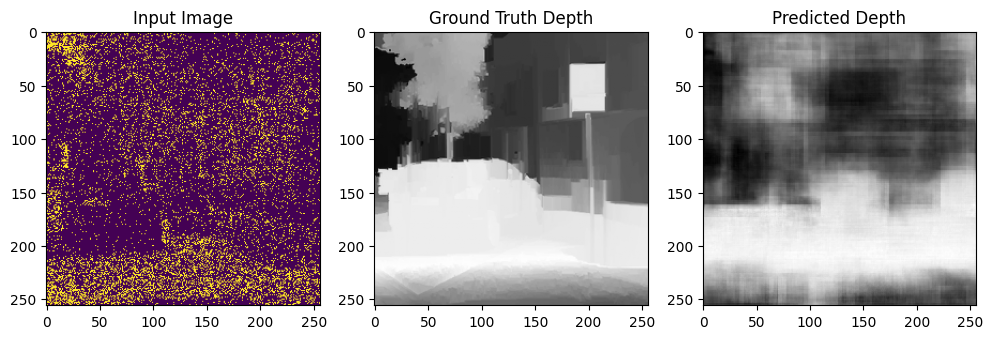

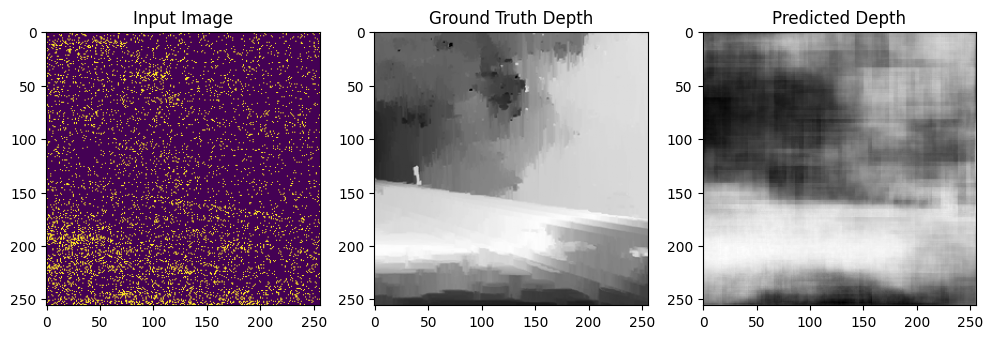

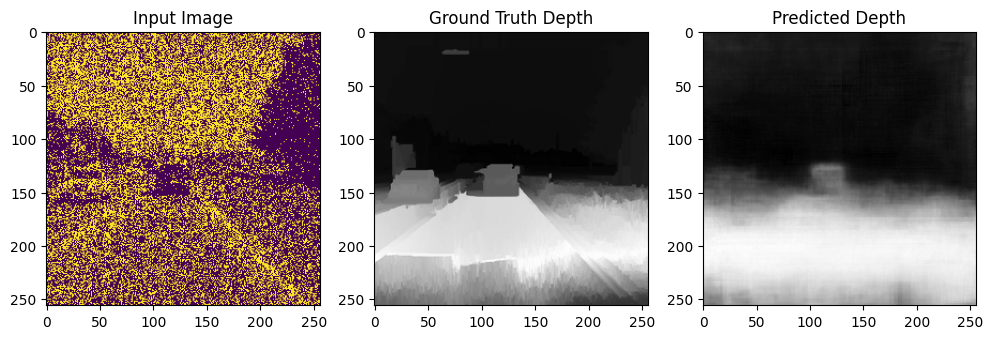

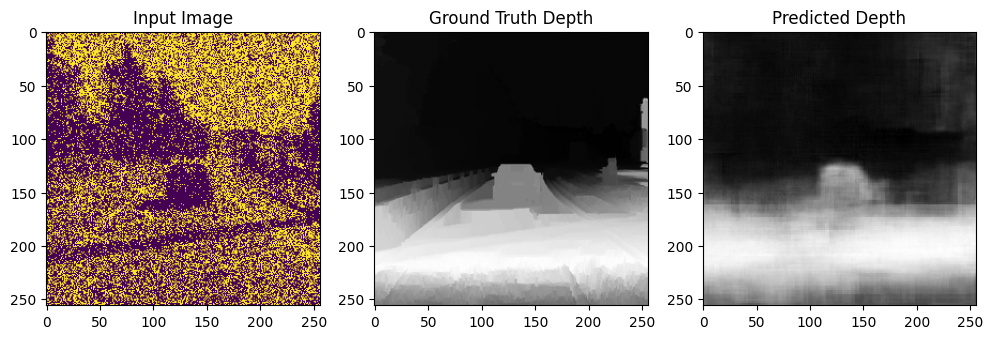

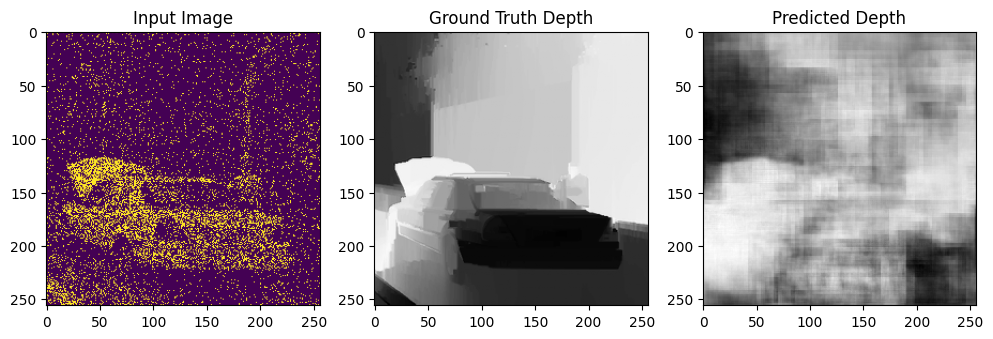

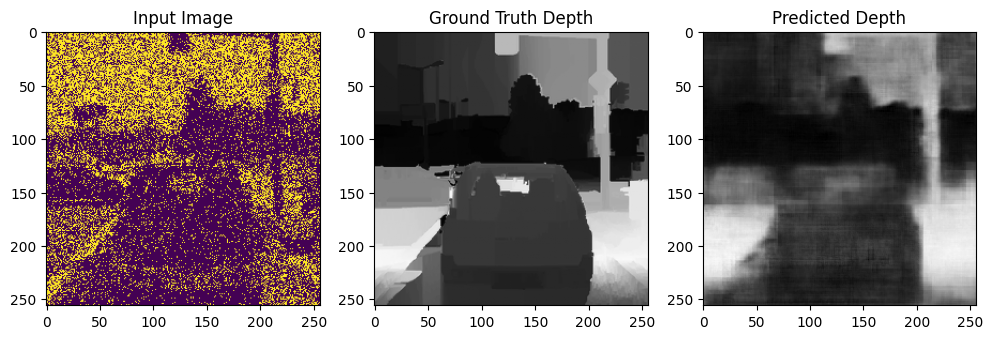

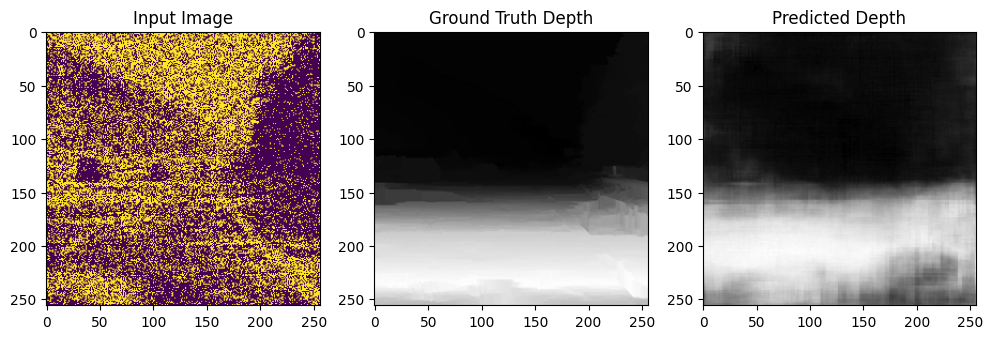

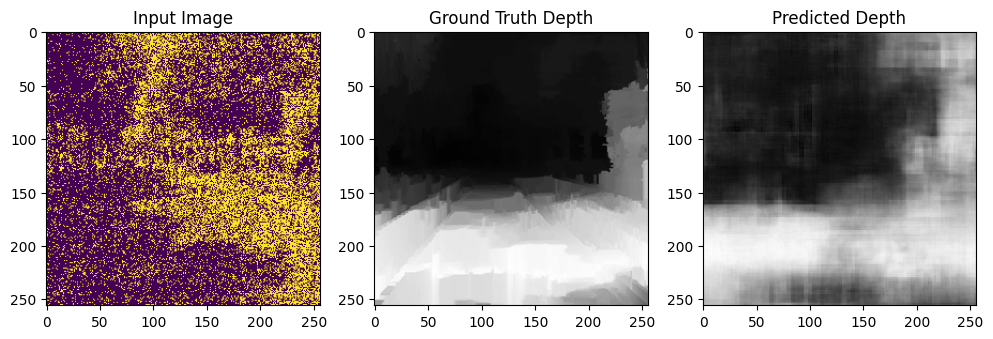

In [14]:
plot_results(model, val_loader, device='mps', num_batches=2)